## 目标检测常见的数据集增强方法

### 常见的数据增强有如下的几种方式

#### 包括:
1. 裁剪(需改变bbox相应的坐标)
2. 平移(需改变bbox相应的坐标)
3. 改变亮度
4. 加噪声
5. 旋转角度(需要改变bbox相应的坐标)
6. 镜像(需要改变bbox相应的坐标)
7. cutout

In [107]:
import cv2
import time
import random
import os
import math
import numpy as np
from skimage.util import random_noise
from skimage import exposure
import matplotlib.pyplot as plt

In [108]:
##定义显示图片的一个方法
def show_pic(img0,img1,bboxes0=None,bboxes1=None):
    """
    输入：
        img:图像array
        bboxes：图像的所有bounding box list，格式为[[x_min,y_min,x_max,y_max]....]
        names:每个box对应的名称
    """
    for i in range(len(bboxes0)):
        bbox=bboxes0[i]
        x_min=bbox[0]
        y_min=bbox[1]
        x_max=bbox[2]
        y_max=bbox[3]
        cv2.rectangle(img0,(int(x_min),int(y_min)),(int(x_max),int(y_max)),(0,255,0),2)
    for i in range(len(bboxes1)):
        bbox=bboxes1[i]
        x_min=bbox[0]
        y_min=bbox[1]
        x_max=bbox[2]
        y_max=bbox[3]
        cv2.rectangle(img1,(int(x_min),int(y_min)),(int(x_max),int(y_max)),(0,255,0),1)
    cv2.imwrite('./1.jpg',img0)
    img0=cv2.imread('./1.jpg')
    cv2.imwrite('./2.jpg',img1)
    img1=cv2.imread('./2.jpg')
    plt.subplot(121)
    plt.imshow(img0[:,:,::-1])
    plt.title("origin")
    plt.subplot(122)
    plt.title("aug")
    plt.imshow(img1[:,:,::-1])
    plt.show()
    os.remove('./1.jpg')
    os.remove('./2.jpg')

### 这里先写一个读取xml信息的工具类，这里有很多实现的代码

In [109]:
import xml.etree.ElementTree as ET
import xml.dom.minidom as DOC

In [110]:
#从xml文件中提取bounding box信息，格式为[[x_min,y_min,x_max,y_max,name]]
def parse_xml(xml_path):
    tree=ET.parse(xml_path)
    root=tree.getroot()
    objs=root.findall('object')
    coords=list()
    for ix,obj in enumerate(objs):
        name=obj.find('name').text
        box=obj.find('bndbox')
        x_min=int(box[0].text)
        y_min=int(box[1].text)
        x_max=int(box[2].text)
        y_max=int(box[3].text)
        coords.append([x_min,y_min,x_max,y_max,name])
    return coords

### 测试图片的具体效果

In [111]:
img=cv2.imread('cat.jpg')
coords=parse_xml('cat.xml')
_coords=[coord[:4] for coord in coords]

### 给图片添加噪声，这里主要通过skimage进行操作

In [112]:
from skimage.util import random_noise
def _addNoise(img):
    '''
    输入：
        array格式的图片
    输出：
        加噪声后的图像array，由于输出的像素在[0,1]之间，所以要乘以255
    '''
    return random_noise(img,mode='gaussian',clip=True)*255

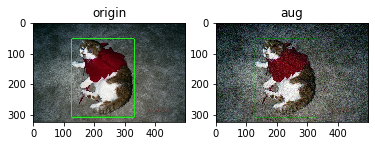

In [113]:
#添加噪声后的图像效果展示
noise_img=_addNoise(img)
show_pic(img,noise_img,_coords,_coords)

#### 调整图片的亮度

In [114]:
#调整图片的亮度
import random
from skimage.exposure import exposure
def changeLight(img):
    flag=random.uniform(0.5,1.5)#flag大于1为调暗，小于1为调亮
    return exposure.adjust_gamma(img,flag)

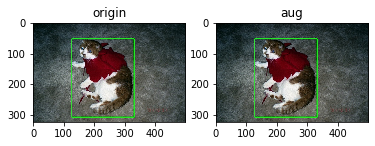

In [115]:
#亮度调整后的图像效果展示
light_img=changeLight(img)
show_pic(img,light_img,_coords,_coords)

#### 将图片裁剪需要对坐标做相应的改变

In [116]:
#裁剪
def _crop_img_bboxes(img,bboxes):
    """
    输入：
        array:img
        bboxes:坐标值，一个list包含了每个元素的[x_min,y_min,x_max,y_max]确保是数值
    输出：
        crop_img：裁剪后的图像array
        crop_bboxes:裁剪后的bounding  box的坐标list
    """
    #--------------------裁剪图像------------------
    w=img.shape[1]
    h=img.shape[0]
    x_min=w #裁剪后的包含所有目标框的最小框的宽
    x_max=0
    y_min=h #裁剪后的包含所有目标框的最小框的高
    y_max=0
    for bbox in bboxes:
        x_min=min(x_min,bbox[0])
        y_min=min(y_min,bbox[1])
        x_max=max(x_max,bbox[2])
        y_max=max(y_max,bbox[3])
    d_to_left=x_min #包含所有目标框的最小框到左边的距离
    d_to_right=w-x_max#包含所有目标框的最小框到右边的距离
    d_to_top=y_min #包含所有目标框的最小框到顶端的距离
    d_to_bottom=h-y_max #包含所有目标框的最小框到底部的距离
    #随机扩展这个最小框
    crop_x_min=int(x_min-random.uniform(0,d_to_left))
    crop_y_min=int(y_min-random.uniform(0,d_to_top))
    crop_x_max=int(x_max+random.uniform(0,d_to_right))
    crop_y_max=int(y_max+random.uniform(0,d_to_bottom))
    #确保不要越界
    crop_x_min=max(0,crop_x_min)
    crop_y_min=max(0,crop_y_min)
    crop_x_max=min(w,crop_x_max)
    crop_y_max=min(h,crop_y_max)
    
    #获取截取后的图片
    crop_img=img[crop_y_min:crop_y_max,crop_x_min:crop_x_max]
    #-----------------------裁剪boundingbox
    #裁剪后的boundingbox坐标计算
    crop_bboxes=list()
    for bbox in bboxes:
        crop_bboxes.append([bbox[0]-crop_x_min,bbox[1]-crop_y_min,bbox[2]-crop_x_min,bbox[3]-crop_y_min])
    return crop_img,crop_bboxes

##### 裁剪后的图片效果对比

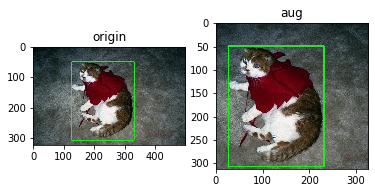

In [117]:
crop_img,crop_bboxes=_crop_img_bboxes(img,_coords)
show_pic(img,crop_img,_coords,crop_bboxes)

#### 旋转增强

In [127]:
# 旋转
def rotate_img_bbox(img,bboxes,angle=5,scale=1.):
    """
    输入：
         img:图像array,(h,w,c)
         bboxs:boundingboxs，一个list,每个元素为[x_min,y_min,x_max,y_max]确保是数值
         angle：旋转角度
         scale:默认1
    输出：
         rot_img:旋转后的图像array
         rot_bboxes:旋转后的boundingbox坐标list
    """
    #-----------------旋转图像--------------------
    w=img.shape[1]
    h=img.shape[0]
    #角度变弧度
    rangle=np.deg2rad(angle)#angle in radians
    #计算新图像的宽和高
    nw=(abs(np.sin(rangle)*h)+abs(np.cos(rangle)*w))*scale
    nh=(abs(np.cos(rangle)*h)+abs(np.sin(rangle)*w))*scale
    #通过OpenCV来获得旋转矩阵
    rot_mat=cv2.getRotationMatrix2D((nw*0.5,nh*0.5),angle,scale)
    #计算从旧的中心点移动到新的中心点通过旋转矩阵
    rot_move=np.dot(rot_mat,np.array([(nw-w)*0.5,(nh-h)*0.5,0]))
    #移动的距离只影响转换，所以这里要更新转换位置
    rot_mat[0,2]+=rot_move[0]
    rot_mat[1,2]+=rot_move[1]
    #仿射变换
    rot_img=cv2.warpAffine(img,rot_mat,(int(math.ceil(nw)),int(math.ceil(nh))),flags=cv2.INTER_LANCZOS4)
    #------------------矫正bbox坐标-----------------
    # rot_img 最终的旋转矩阵
    # 获取原始bbox的四个中点，然后将这四个点转换到旋转后的坐标系下
    rot_bboxes=list()
    for bbox in bboxes:
        xmin=bbox[0]
        ymin=bbox[1]
        xmax=bbox[2]
        ymax=bbox[3]
        x_center=(xmin+xmax)/2
        y_center=(ymin+ymax)/2
        point1=np.dot(rot_mat,np.array([x_center,ymin,1]))
        point2=np.dot(rot_mat,np.array([xmax,y_center,1]))
        point3=np.dot(rot_mat,np.array([x_center,ymax,1]))
        point4=np.dot(rot_mat,np.array([xmin,y_center,1]))
        #合并 np.array
        concat=np.vstack((point1,point2,point3,point4))
        #改变 array 类型
        concat=concat.astype(np.int32)
        #得到旋转后的坐标
        rx,ry,rw,rh=cv2.boundingRect(concat)
        rx_min=rx
        ry_min=ry
        rx_max=rx+rw
        ry_max=ry+rh
        rot_bboxes.append([rx_min,ry_min,rx_max,ry_max])
    return rot_img,rot_bboxes

##### 显示旋转后的图片效果

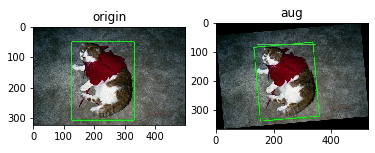

In [130]:
rote_img,rote_bboxes=rotate_img_bbox(img,_coords)
show_pic(img,rote_img,_coords,rote_bboxes)

#### 平移增强

In [133]:
# 平移
def shift_img_bbox(img,bboxes):
    """
    输入：
         img:图像array,(h,w,c)
         bboxs:boundingboxs，一个list,每个元素为[x_min,y_min,x_max,y_max]确保是数值
    输出：
         shift_img:平移后的图像array
         shift_bboxes:平移后的bounding box坐标list
    """
    #---------------平移图像-----------------
    w=img.shape[1]
    h=img.shape[0]
    x_min=w #裁剪后的包含所有目标框的最小框的宽
    x_max=0
    y_min=h #裁剪后的包含所有目标框的最小框的高
    y_max=0
    for bbox in bboxes:
        x_min=min(x_min,bbox[0])
        y_min=min(y_min,bbox[1])
        x_max=max(x_max,bbox[2])
        y_max=max(y_max,bbox[3])
    d_to_left=x_min #包含所有目标的最大左移动距离
    d_to_right=w-x_max #包含所有目标框最大右移动距离
    d_to_top=y_min #包含所有目标框的最大上移动距离
    d_to_bottom=h-y_max #包含所有目标框的最大下移动距离
    x=random.uniform(-(d_to_left-1)/3,(d_to_right-1)/3)
    y=random.uniform(-(d_to_top-1)/3,(d_to_bottom-1)/3)
    
    M=np.float32([[1,0,x],[0,1,y]])#x为向左或向右移动的像素值，正为向右负为向左；y为向上或者向下移动的像素值，正为向下负为向上
    shift_img=cv2.warpAffine(img,M,(img.shape[1],img.shape[0]))
    
    #----------------------平移boundingbox
    shift_bboxes=list()
    for bbox in bboxes:
        shift_bboxes.append([bbox[0]+x,bbox[1]+y,bbox[2]+x,bbox[3]+y])
    return shift_img,shift_bboxes

##### 显示平移后的图像

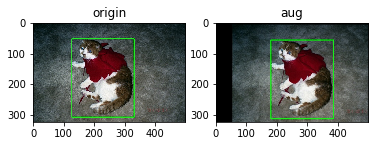

In [134]:
shift_img,shift_bboxes=shift_img_bbox(img,_coords)
show_pic(img,shift_img,_coords,shift_bboxes)

#### 对图像做镜像增强处理

In [135]:
# 镜像增强
def flip_img_bbox(img,bboxes):
    """
    输入：
         img:图像array,(h,w,c)
         bboxs:boundingboxs，一个list,每个元素为[x_min,y_min,x_max,y_max]确保是数值
    输出：
         flip_img:镜像后的图像array
         flip_bboxes:镜像后的bounding box坐标list
    """
    #----------翻转图像---------------
    import copy
    flip_img=copy.deepcopy(img)
    if random.random()<0.5:#0.5的概率水平翻转，0.5的概率垂直翻转
        horizon=True
    else:
        horizon=False
    h,w,_=img.shape
    
    if horizon:#水平翻转
        flip_img=cv2.flip(flip_img,1)#1是水平，-1是水平垂直
    else:
        flip_img=cv2.flip(flip_img,0)
    #--------------------------调整boundingbox-----------
    flip_bboxes=list()
    for box in bboxes:
        x_min=box[0]
        y_min=box[1]
        x_max=box[2]
        y_max=box[3]
        
        if horizon:
            flip_bboxes.append([w-x_max,y_min,w-x_min,y_max])
        else:
            flip_bboxes.append([x_min,h-y_max,x_max,h-y_min])
    return flip_img,flip_bboxes

##### 显示平移后的图像变换

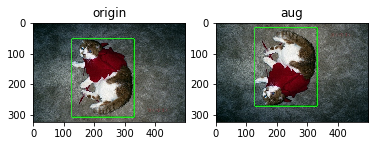

In [137]:
flip_img,flip_bboxes=flip_img_bbox(img,_coords)
show_pic(img,flip_img,_coords,flip_bboxes)

### CutOut数据增强方式

In [138]:
#cutout
def cutout(img,bboxes,length=100,n_holes=1,threshold=0.5):
    """
    输入：
        img:array图片 (h,w,c)
        bboxes:框的坐标框
        n_holes(int):每副图片有多少需要遮掉
        length(int): 每平方的像素
    """
    #计算Iou
    def cal_iou(boxA,boxB):
        xA=max(boxA[0],boxB[0])
        yA=max(boxA[1],boxB[1])
        xB=min(boxA[2],boxB[2])
        yB=min(boxA[3],boxB[3])
        
        if xB<=xA or yB<=yA:
            return 0.0
        #计算交集的面积
        interArea=(xB-xA+1)*(yB-yA+1)
        boxAArea=(boxA[2]-boxA[0]+1)*(boxA[3]-boxA[1]+1)
        boxBArea=(boxB[2]-boxB[0]+1)*(boxB[3]-boxB[1]+1)
        
        iou=interArea/float(boxAArea+boxBArea-interArea)
        return iou
    #得到h和w
    if img.ndim==3:
        h,w,c=img.shape
    else:
        _,h,w,c=img.shape
    mask=np.ones((h,w,c),np.float32)
    for n in range(n_holes):
        flag=True #看切割的区域是否与box重叠太多
        while flag:
            y=np.random.randint(h)
            x=np.random.randint(w)
            
            y1=np.clip(y-length//2,0,h)#clip将数组中的元素限制在a_min,a_max之间，大于a_max就让他等于a_max,小于a_min就等于a_min
            y2=np.clip(y+length//2,0,h)
            x1=np.clip(x-length//2,0,w)
            x2=np.clip(x+length//2,0,w)
            flag=False
            for box in bboxes:
                if cal_iou([x1,y1,x2,y2],box)>threshold:
                    flag=True
                    break
            
            
        mask[y1:y2,x1:x2,:]=0
    img=img*mask
    return img

#### 显示cutout增强的效果

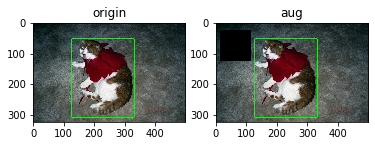

In [150]:
cutout_img=cutout(img,_coords)
show_pic(img,cutout_img,_coords,_coords)